## YOLO이용한 객체 탐지, 분할 그리고 길이 측정 

YOLO 모델을 활용, 이미지 분

In [ ]:
from ultralytics import YOLO, SAM
import cv2
import numpy as np
import matplotlib.pyplot as plt
import openai
import json

yolo_model = YOLO("yolo11n.pt")

results = yolo_model('sample.jpg')

results

: 

In [ ]:
boxes = results[0].boxes
boxes.cls

tensor([64., 56., 62., 41., 64., 64., 66., 66., 41., 41.])

In [23]:
for box in boxes:
    class_id = int(box.cls)
    class_name = yolo_model.names[class_id]
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    width_px = x2 - x1
    height_px = y2 - y1

    print(f"{class_name}: {width_px:.1f}px × {height_px:.1f}px")

mouse: 191.2px × 136.0px
chair: 1414.1px × 729.9px
tv: 1304.9px × 739.3px
cup: 262.9px × 289.0px
mouse: 315.0px × 217.7px
mouse: 277.5px × 129.9px
keyboard: 1096.0px × 293.2px
keyboard: 862.9px × 236.2px
cup: 222.8px × 185.7px
cup: 239.1px × 396.8px


In [30]:
boxes.cls

tensor([64., 56., 62., 41., 64., 64., 66., 66., 41., 41.])

In [32]:
REFERENCE_WIDTH_mm = 450 
scale_px_per_mm = None
dimensions = {}

for box in boxes:
    class_id = int(box.cls)
    class_name = yolo_model.names[class_id]
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    width_px = x2 - x1
    height_px = y2 - y1

    if class_name == "keyboard":
        scale_px_per_mm = width_px / REFERENCE_WIDTH_mm

for box in boxes:
    class_id = int(box.cls)
    class_name = yolo_model.names[class_id]
    x1, y1, x2, y2 = box.xyxy[0].tolist()
    width_px = x2 - x1
    height_px = y2 - y1

    if class_name != "keyboard" and scale_px_per_mm:
        dimensions[class_name] = {
            "width_mm": round(width_px / scale_px_per_mm, 2),
            "height_mm": round(height_px / scale_px_per_mm, 2)
        }

import json
print(json.dumps(dimensions, indent=2))


{
  "mouse": {
    "width_mm": 144.72,
    "height_mm": 67.72
  },
  "chair": {
    "width_mm": 737.45,
    "height_mm": 380.65
  },
  "tv": {
    "width_mm": 680.48,
    "height_mm": 385.54
  },
  "cup": {
    "width_mm": 124.67,
    "height_mm": 206.93
  }
}


In [31]:
scale_px_per_mm

In [27]:
def show_box(box, ax, color='red'):
    x0, y0, x1, y1 = box  # correct interpretation
    w = x1 - x0
    h = y1 - y0
    rect = plt.Rectangle((x0, y0), w, h, linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)

def visualize_segmented_images(image, results):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)

    for r in results[0].boxes.data.cpu().numpy():
        show_box(r[:-2], ax)

    ax.axis('off')
    plt.tight_layout()
    plt.show()


In [28]:
def extract_crops(image, results):
    cropped_imgs = []
    for r in results[0].boxes.data.cpu().numpy():
        x0, y0, x1, y1 = r[:-2]
        x0, x1 = np.clip([x0, x1], 0, image.shape[1])
        y0, y1 = np.clip([y0, y1], 0, image.shape[0])
        img = image[int(y0):int(y1), int(x0):int(x1)]
        cropped_imgs.append(img)
    return cropped_imgs


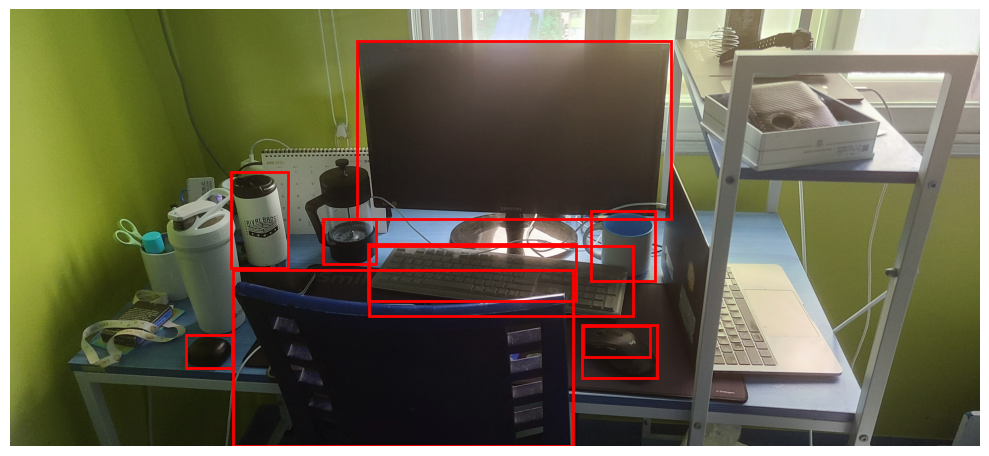

In [36]:
import base64, io
from PIL import Image



visualize_segmented_images(results[0].orig_img, results)